# RNN for japanese character classification

In [86]:
import time
import math
import random

import sys
import inspect
import os
import glob
import csv

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from src.data.build_features import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
from google.colab import drive, files
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


## Define network structure

In [97]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        # combine along first dimension
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        # initialize hidden-state
        return torch.zeros(1, self.hidden_size)

## Define helper functions for neural network's training

In [98]:
def train(file_tensor, character_tensor):
    hidden = rnn.init_hidden().to(device)
    
    # iterate over seq_lenght to get last output
    for i in range(file_tensor.size()[0]):
        output, hidden = rnn(file_tensor[i], hidden)
        
    loss = criterion(output, character_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [99]:
# load train dataset
character_files, all_characters = load_data(path="../data/train/")

n_features = 3 # input_size -> x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128

learning_rate = 0.001

## Start training loop

In [18]:
# initialize neural network
rnn = RNN(n_features, hidden_size, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 2000
plot_every = 500
n_iters = 20000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

2000 10% (2m 13s) 1.5236 data/train/e__19736.csv / e ✓
4000 20% (4m 24s) 1.4548 data/train/o__85130.csv / u ✗ (o)
6000 30% (6m 34s) 1.5647 data/train/a__38791.csv / e ✗ (a)
8000 40% (8m 43s) 1.4175 data/train/a__77402.csv / e ✗ (a)
10000 50% (10m 49s) 1.4158 data/train/i__35733.csv / a ✗ (i)
12000 60% (13m 1s) 0.9550 data/train/u__45378.csv / o ✗ (u)
14000 70% (15m 12s) 0.8708 data/train/e__28466.csv / e ✓
16000 80% (17m 22s) 0.0007 data/train/e__06730.csv / e ✓
18000 90% (19m 33s) 1.7877 data/train/e__53786.csv / a ✗ (e)
20000 100% (21m 45s) 1.4626 data/train/i__22628.csv / a ✗ (i)


## Plot LOSS-function

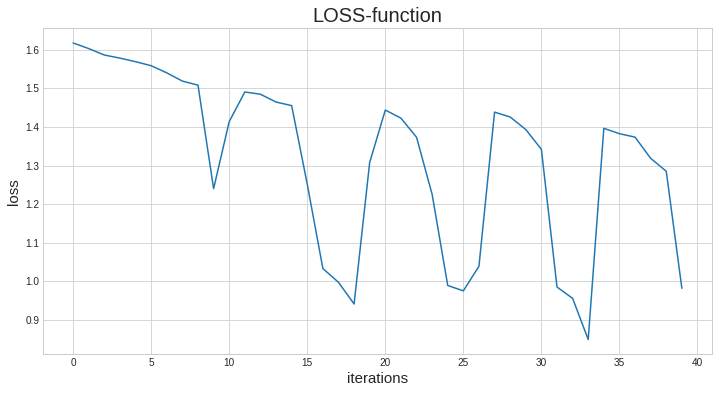

In [19]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [20]:
FILE = "../models/2.0-recurrent-neural-network-model.pth"
torch.save(rnn.state_dict(), FILE)

## Load model

In [100]:
FILE = "../models/2.0-recurrent-neural-network-model.pth"
loaded_model = RNN(n_features, hidden_size, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()

RNN(
  (i2h): Linear(in_features=131, out_features=128, bias=True)
  (i2o): Linear(in_features=131, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
../data/test\a__88470.csv / a ✓
../data/test\a__94789.csv / a ✓
../data/test\a__96486.csv / a ✓
../data/test\a__97545.csv / a ✓
../data/test\a__98539.csv / a ✓
../data/test\e__70433.csv / e ✓
../data/test\e__76682.csv / e ✓
../data/test\e__82254.csv / e ✓
../data/test\e__83191.csv / e ✓
../data/test\e__84585.csv / e ✓
../data/test\i__75461.csv / i ✓
../data/test\i__81833.csv / o ✗ (i)
../data/test\i__88644.csv / o ✗ (i)
../data/test\i__89095.csv / i ✓
../data/test\i__91889.csv / u ✗ (i)
../data/test\o__54903.csv / u ✗ (o)
../data/test\o__63253.csv / o ✓
../data/test\o__67824.csv / o ✓
../data/test\o__72419.csv / o ✓
../data/test\o__76748.csv / o ✓
../data/test\u__81848.csv / o ✗ (u)
../data/test\u__82120.csv / o ✗ (u)
../data/test\u__83897.csv / o ✗ (u)
../data/test\u__85976.csv / u ✓
../data/test\u__88458.csv / o ✗ (u)
../data/test\u__93521.csv / o ✗ (u)

accuracy = 65.38 %



<ipython-input-101-3a7d86f00275>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_characters, rotation=90)
<ipython-input-101-3a7d86f00275>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_characters)


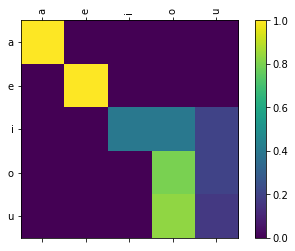

In [101]:
# load test dataset
character_files, all_characters = load_data("../data/test/")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            hidden = loaded_model.init_hidden().to(device)
            # iterate over seq_lenght to get last output
            for i in range(file_tensor.size()[0]):
                output, hidden = loaded_model(file_tensor[i], hidden)
            
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, "/", guess, correct)

# normalize by dividing every row by its sum
for i in range(n_characters):
    confusion[i] = confusion[i] / confusion[i].sum()
    
acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_characters, rotation=90)
ax.set_yticklabels([''] + all_characters)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()